In [1]:
import pathlib
import dask.dataframe as dd
import psutil
import numpy as np
import pandas as pd

In [2]:
# print amount of available RAM memory
print(f"Available RAM: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

Available RAM: 2.53 GB


In [3]:
#n_samples = 100_000_000
n_samples = 1_000_000
distance_mean_m = 100
distance_sigma_m = 10
time_mean_s = 10
time_sigma_s = 0.1

In [4]:
df = pd.DataFrame(
    {
        "distance_m" : np.random.normal(loc=distance_mean_m, scale=distance_sigma_m, size=n_samples),
        "time_s": np.random.normal(loc=time_mean_s, scale=time_sigma_s, size=n_samples)
    }
)

In [5]:
df.to_hdf("speed.h5", key="df", mode="w", complevel=5, complib="blosc:zstd", format="table")

In [6]:
df2 = pd.read_hdf("speed.h5", key="df")

In [7]:
df2.head()

,distance_m,time_s
0,104.913506,10.019038
1,84.730630,10.048232
2,94.462363,9.904450
3,100.056679,9.999534
4,88.232347,10.108677


In [8]:
hist, xedges, yedges = np.histogram2d(df2.distance_m, df2.time_s, bins=500)

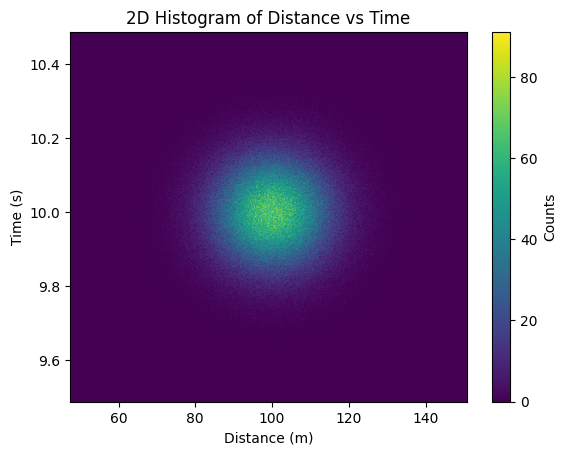

In [9]:
# plot the histogram
import matplotlib.pyplot as plt
plt.imshow(hist.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.title('2D Histogram of Distance vs Time')
plt.colorbar(label='Counts')
plt.show()

In [10]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43929,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39845,Total threads: 3
Dashboard: http://127.0.0.1:36823/status,Memory: 3.82 GiB
Nanny: tcp://127.0.0.1:43243,


In [11]:
df = dd.read_hdf("speed.h5", key="df")

In [12]:
df.head()

,distance_m,time_s
0,104.913506,10.019038
1,84.730630,10.048232
2,94.462363,9.904450
3,100.056679,9.999534
4,88.232347,10.108677


In [30]:
import dask.array as da

x = df.distance_m.to_dask_array(lengths=True)
y = df.time_s.to_dask_array(lengths=True)

# Compute min/max first
x_min, x_max, y_min, y_max = da.compute(x.min(), x.max(), y.min(), y.max())

# Use the computed numbers
H, xedges, yedges = da.histogram2d(
    x, y,
    bins=(500, 500),
    range=[[x_min, x_max], [y_min, y_max]]
)

In [31]:
H, xedges, yedges = da.compute(H, xedges, yedges)

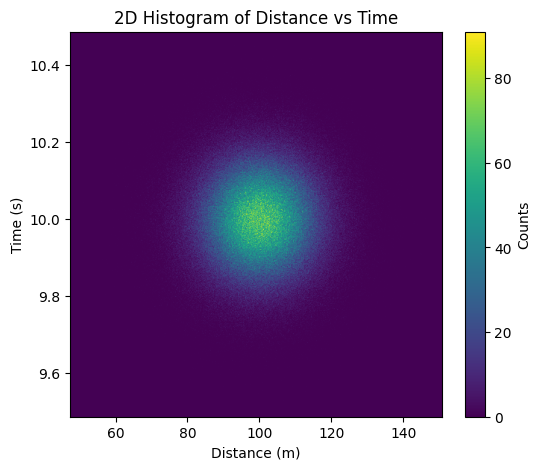

In [33]:
plt.figure(figsize=(6, 5))
plt.imshow(
    H.T,                          # transpose for correct orientation
    origin="lower",
    aspect="auto",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap="viridis"
)
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")
plt.title("2D Histogram of Distance vs Time")
plt.colorbar(label="Counts")
plt.show()